In [1]:
import mmh3
import re
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np
from scipy.stats import chisquare
import warnings
warnings.filterwarnings('ignore')
from time import time

In [2]:
def get_sorted_counts(data):
    unique, counts = np.unique(data, return_counts=True)
    counts[::-1].sort()
    return counts

In [3]:
def chisquare_test(counts, power=1.16, alpha=1):
    skip = int(0.005*len(counts))
    
    frequencies = np.array([alpha / np.power(i, power) for i in range(1, len(counts) + 1)])
    zipf_counts = frequencies

    chi = chisquare(counts[skip:], zipf_counts[skip:])
    return chi[1]

In [4]:
def parameter_estimation(sample):
    unique, counts = np.unique(sample, return_counts=True)
    counts[::-1].sort()
    max_counts=counts[0]
    start = 10
    counts = counts[np.where(counts >= 5)]
    counts = counts[start:]
    
    m = len(counts)
    if m>1:
        logf = np.log(counts)
        logn = np.log(np.arange(start=1, stop=m + 1, step=1) + start)

        sum_logf = np.sum(logf)
        sum_logn = np.sum(logn)
        dot_logf_logn=np.dot(logf, logn)    
        dot_logn_logn=np.dot(logn, logn)
        s = (m * dot_logf_logn / sum_logn  - sum_logf) / (sum_logn  - m * dot_logn_logn / sum_logn )
        alpha = np.exp((s * dot_logn_logn + dot_logf_logn) / sum_logn)
        return (s, alpha)
    else:
        return (1,max_counts)


In [5]:
def hash_distributed_test(test, sample, distributed_sample, paral_size=10):
    for el in sample:
        distributed_sample[mmh3.hash(str('qwerty' + str(el))) % paral_size].append(el)

    p_values = {}
    for ds in distributed_sample:
        data = distributed_sample[ds]

        counts = get_sorted_counts(data)
        power, alpha = parameter_estimation(data)
        p_values[ds] = test(counts, power, alpha)
        
    return p_values

In [6]:
def plot_partitions(ps, partitions):
    plt.figure(figsize=(15, 15))
    plt.subplots_adjust(hspace=0.4)
    for idx, (part, data) in enumerate(partitions.items()):
        rows = (1 + ps) * ps // 4
        plt.subplot(rows, 2, idx + 1)
        plt.scatter(*zip(*data[:4000]),s=1)
        plt.xlabel('size')
        plt.ylabel('p-value')
        plt.title('Partition: ' + part)
    plt.show()

In [7]:
def test_batch_size(words, batch_size=100):
    text_size=len(words)
    partitions = defaultdict(list)
    tests = {'chi': chisquare_test}
    
    max_paral_size = 4
    paral_sizes = range(1, max_paral_size + 1)
    
    for name in tests:
        for ps in paral_sizes:
            distributed_sample = defaultdict(list)
            for boundary in range(batch_size, text_size, batch_size):
                p_values = hash_distributed_test(tests[name], words[boundary - batch_size:boundary],
                                                 distributed_sample,
                                                 paral_size=ps)
                for i in range(ps):
                    if i in p_values:
                        partitions[str(ps) + '.' + str(i)].append((boundary, p_values[i]))
    plot_partitions(max_paral_size, partitions)

# Test war and peace

In [8]:
file = open('war_and_peace.txt', 'r')
text = file.read().lower()
words = re.sub('\W', ' ', text).split()[:10000]


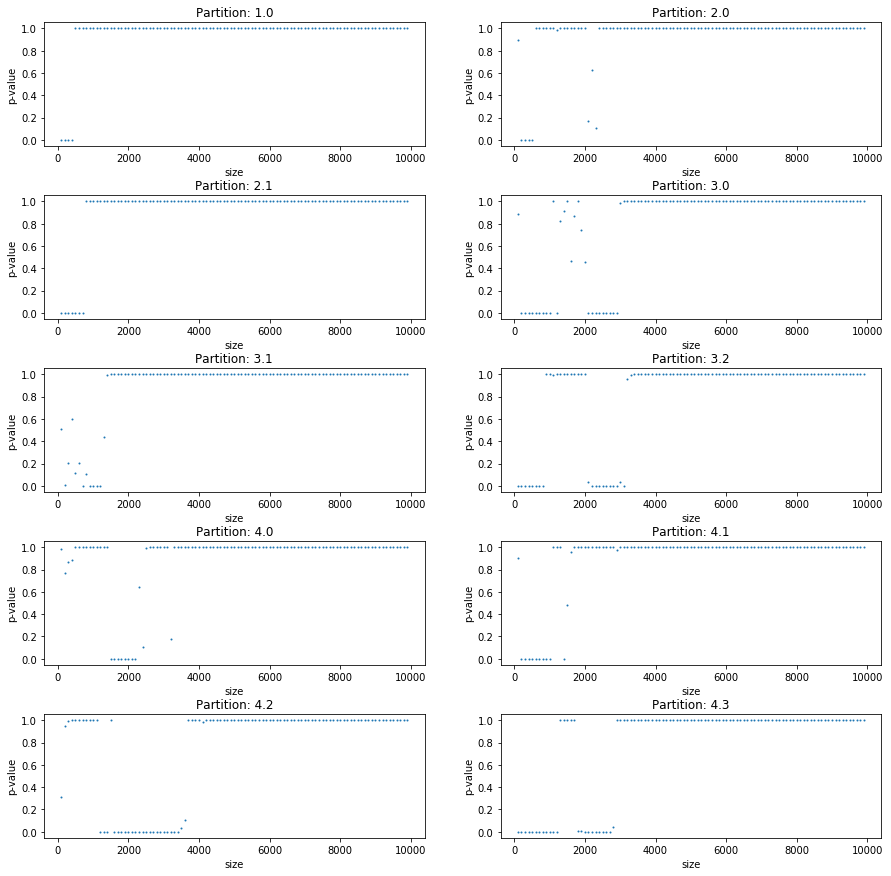

In [9]:
test_batch_size(words,100)

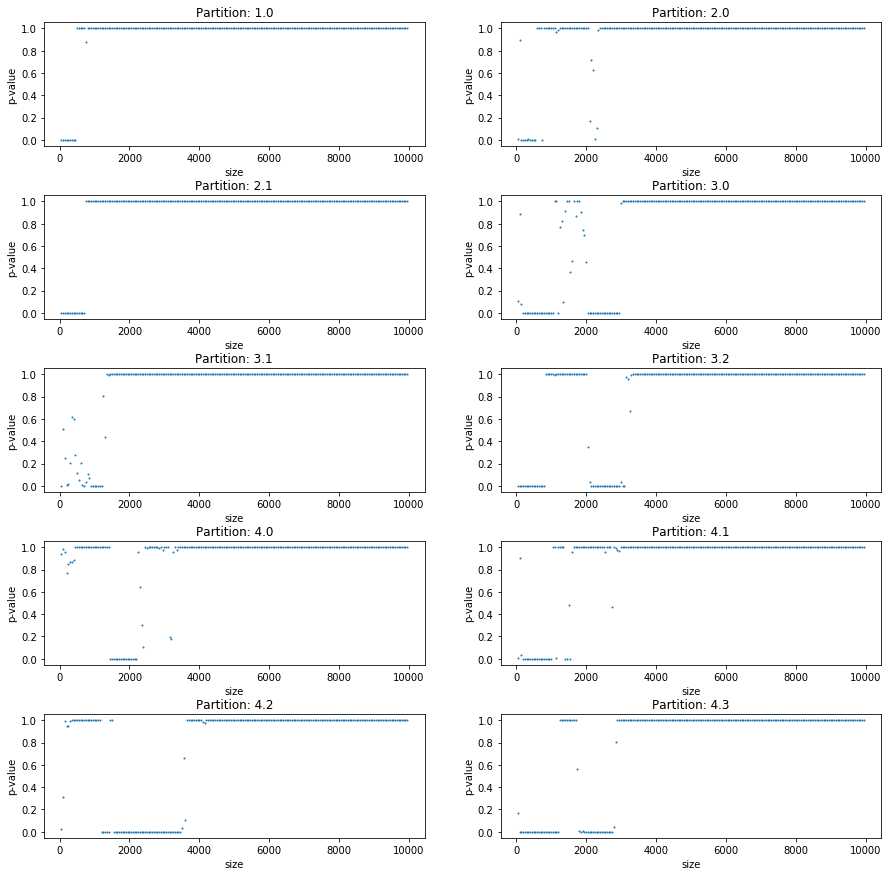

In [10]:
test_batch_size(words,50)

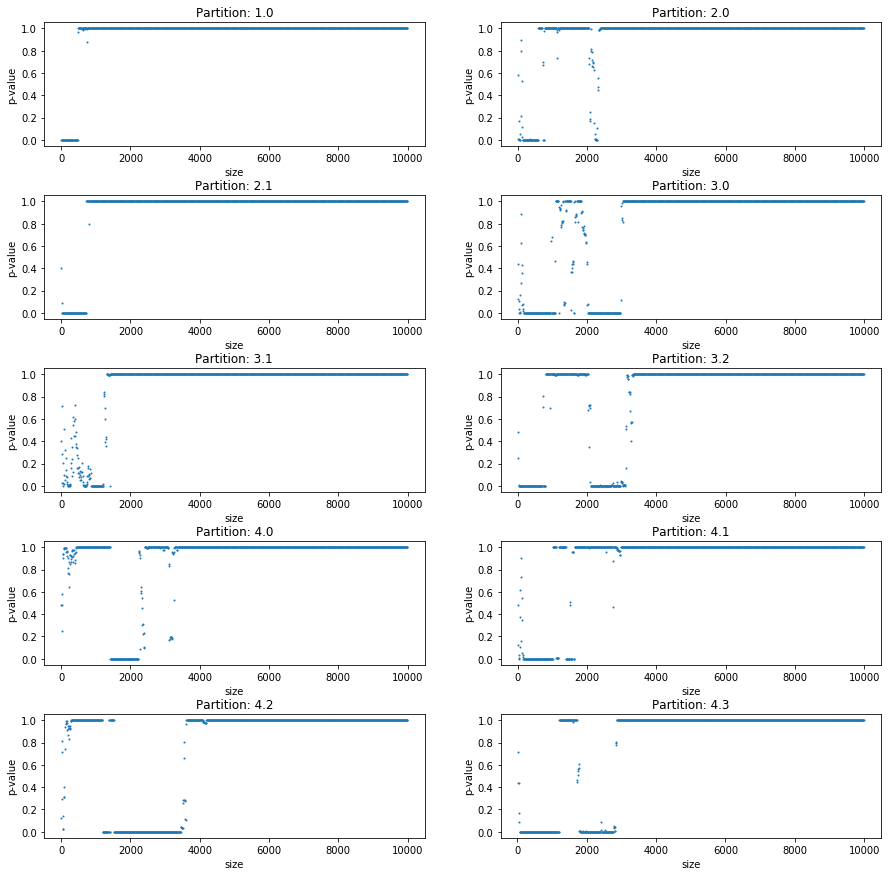

In [11]:
test_batch_size(words,10)

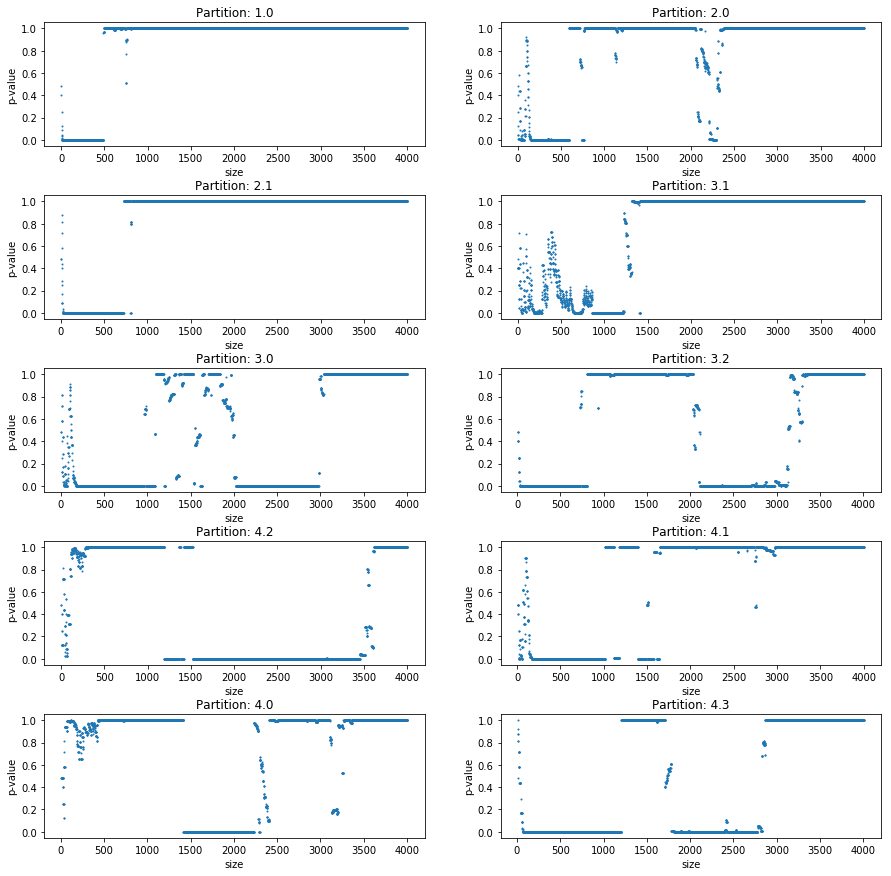

In [12]:
test_batch_size(words, 1)

# Test exponential distribution

In [13]:
sample = np.random.exponential(scale=1.0 / 0.125, size=10000)
words = np.array(sample, dtype=np.int)

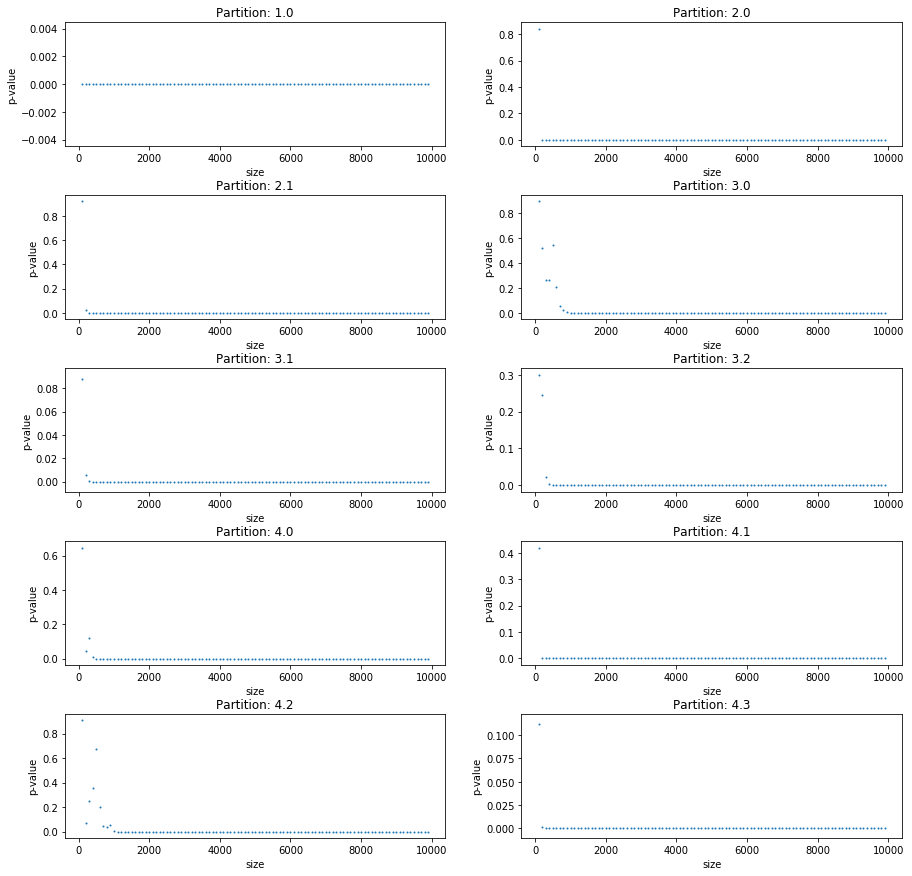

In [14]:
test_batch_size(words,100)

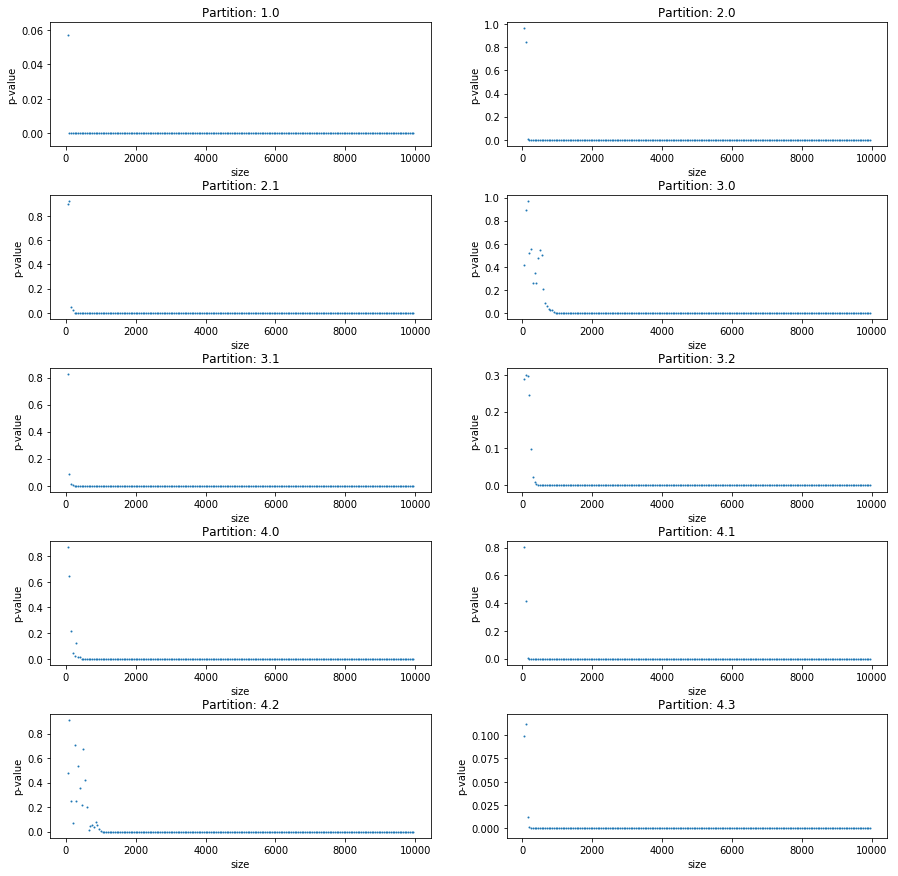

In [15]:
test_batch_size(words,50)

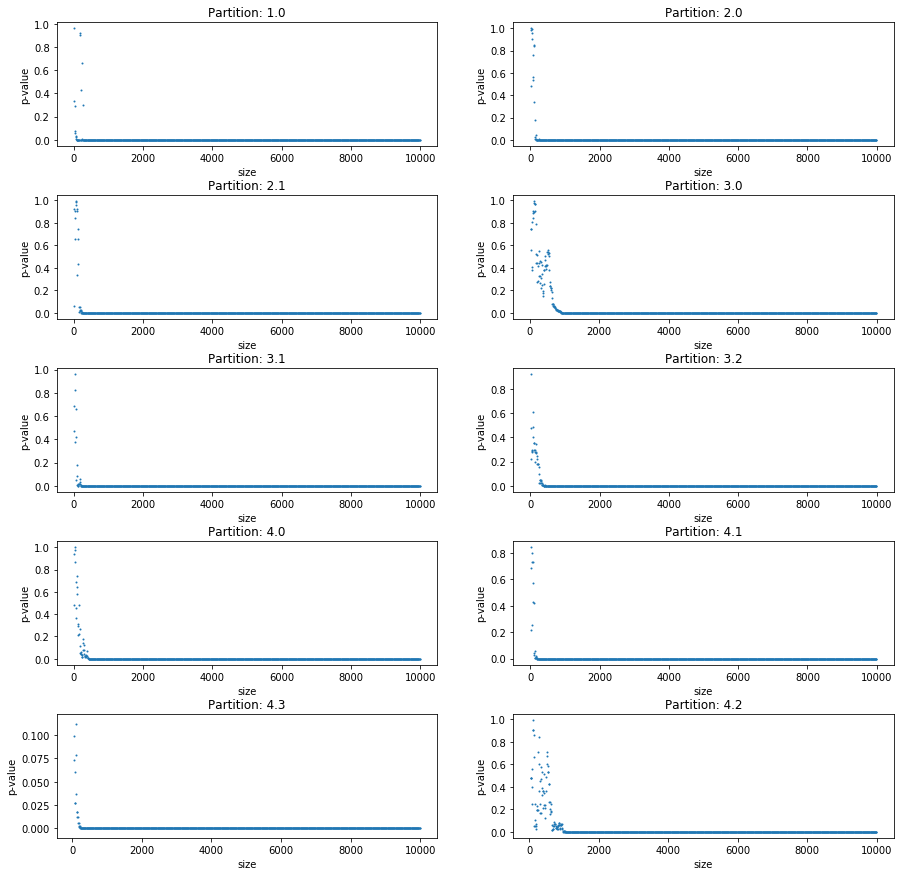

In [16]:
test_batch_size(words,10)

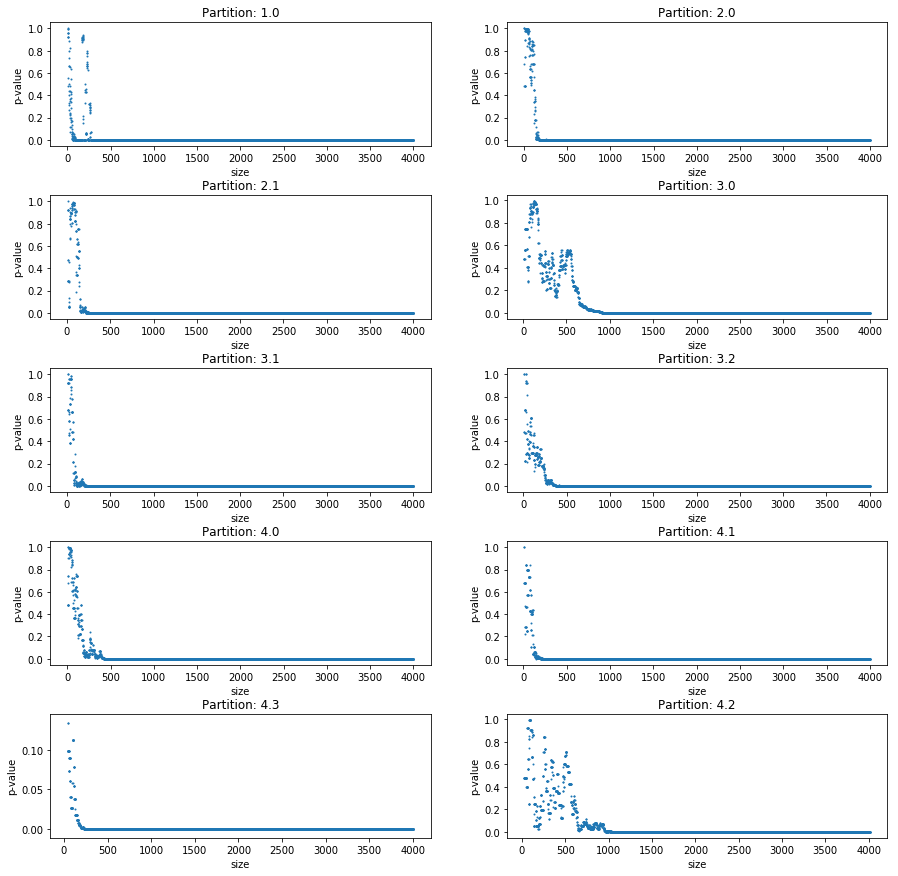

In [17]:
test_batch_size(words,1)